In [1]:
import nest_asyncio
nest_asyncio.apply()

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from genparse.experimental.batch_inference import (
    BatchVLLM, BatchLLM,
    ParallelCharacterProposal, ParallelTokenProposal,
    SequentialCharBatchProposal, SequentialTokenBatchProposal,
    BatchStepper
)

/home/lebrunb/miniconda3/envs/genparse2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-07-23 16:20:27,858	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [4]:
from genparse.util import lark_guide
guide = lark_guide(open('../benchmark/grammars/tiny_sql.lark', 'r').read())

In [5]:
from genparse.lm import VirtualTokenizedLLM
llm = VirtualTokenizedLLM.from_name('codellama/CodeLlama-7b-Instruct-hf', seed = 0)

INFO 07-23 16:20:33 llm_engine.py:161] Initializing an LLM engine (v0.5.0.post1) with config: model='codellama/CodeLlama-7b-Instruct-hf', speculative_config=None, tokenizer='codellama/CodeLlama-7b-Instruct-hf', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, rope_scaling=None, rope_theta=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=16384, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, quantization_param_path=None, device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='outlines'), seed=0, served_model_name=codellama/CodeLlama-7b-Instruct-hf)


OutOfMemoryError: CUDA out of memory. Tried to allocate 96.00 MiB. GPU 

In [5]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "(true | false)"

In [13]:
from genparse.experimental.inference.proposal_server import CharacterProposalServer, TokenProposalServer
from genparse.experimental.inference.next_token_logprob_server import NextTokenLogProbServer
from genparse.experimental.inference.batch_propose import init_particles, BatchProposal, BatchProposalBaseline

n_processes = 10
token_server = TokenProposalServer(llm=llm, guide=guide, K=20, num_processes=n_processes, max_n_particles=350, seed=0)
logprob_server = NextTokenLogProbServer(llm)
batch_proposal = BatchProposal(token_server, logprob_server, max_tokens = 25)

Initialized proposal server with num_processes=10, max_n_particles=350, seed=0
Initialized batch proposal with eos=▪ and max_tokens=25


In [29]:
batch_proposal.cleanup()

# VLLM vs Proposal

In [26]:
from arsenal.timer import Benchmark

In [30]:
max_tokens = 25
n_processes = 10
N = 10
T = Benchmark(f'Parallel vs Sequential {n_processes=}, {max_tokens=}. Token proposal with K={token_server.K}')

n_processes = 10
token_server = TokenProposalServer(llm=llm, guide=guide, K=20, num_processes=n_processes, max_n_particles=350, seed=0)
logprob_server = NextTokenLogProbServer(llm)
batch_proposal = BatchProposal(token_server, logprob_server, max_tokens = max_tokens)
baseline = BatchProposalBaseline(token_server, logprob_server, max_tokens = max_tokens)

for n_particles in [10, 20, 40, 80, 160]:

    batch_proposal.next_token_logprob_server.add_prompt('Generate an SQL query:')

    for i in range(N):
        particles = init_particles(n_particles=n_particles)
        with T['sequential'](i=i, n_particles=n_particles):
            particles = baseline.batch_step(particles, is_initial=True)
            while not all(p.done for p in particles):
                particles = baseline.batch_step(particles)

        particles = init_particles(n_particles=n_particles)
        with T['parallel'](i=i, n_particles=n_particles):
            particles = batch_proposal.batch_step(particles, is_initial=True)
            while not all(p.done for p in particles):
                particles = batch_proposal.batch_step(particles)

batch_proposal.cleanup()

N = 10
T2 = Benchmark(f'Parallel vs Sequential {n_processes=}, {max_tokens=}. Character Proposal.')

n_processes = 10
proposal_server = CharacterProposalServer(llm=llm, guide=guide, num_processes=n_processes, max_n_particles=350, seed=0)
logprob_server = NextTokenLogProbServer(llm)
batch_proposal = BatchProposal(proposal_server, logprob_server, max_tokens = max_tokens)
baseline = BatchProposalBaseline(proposal_server, logprob_server, max_tokens = max_tokens)

for n_particles in [10, 20, 40, 80, 160]:

    batch_proposal.next_token_logprob_server.add_prompt('Generate an SQL query:')

    for i in range(N):
        particles = init_particles(n_particles=n_particles)
        with T2['sequential'](i=i, n_particles=n_particles):
            particles = baseline.batch_step(particles, is_initial=True)
            while not all(p.done for p in particles):
                particles = baseline.batch_step(particles)

        particles = init_particles(n_particles=n_particles)
        with T2['parallel'](i=i, n_particles=n_particles):
            particles = batch_proposal.batch_step(particles, is_initial=True)
            while not all(p.done for p in particles):
                particles = batch_proposal.batch_step(particles)



Initialized proposal server with num_processes=10, max_n_particles=350, seed=0
Initialized batch proposal with eos=▪ and max_tokens=25
INFO 07-23 03:29:57 metrics.py:341] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 0.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 07-23 03:30:02 metrics.py:341] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 20.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.7%, CPU KV cache usage: 0.0%.


/home/lebrunb/repos/genparse/genparse/experimental/inference/next_token_logprob_server.py:95: UserWarning: Engine has unfinished requests from previous runs. Freeing leftover requests.
  warnings.warn('Engine has unfinished requests from previous runs. Freeing leftover requests.')


INFO 07-23 03:30:07 metrics.py:341] Avg prompt throughput: 1.4 tokens/s, Avg generation throughput: 54.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.5%, CPU KV cache usage: 0.0%.
INFO 07-23 03:30:12 metrics.py:341] Avg prompt throughput: 1.4 tokens/s, Avg generation throughput: 22.5 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.7%, CPU KV cache usage: 0.0%.
INFO 07-23 03:30:18 metrics.py:341] Avg prompt throughput: 2.3 tokens/s, Avg generation throughput: 44.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 07-23 03:30:23 metrics.py:341] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 34.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.4%, CPU KV cache usage: 0.0%.
INFO 07-23 03:30:28 metrics.py:341] Avg prompt throughput: 2.6 tokens/s, Avg generation throughput: 43.7 tokens/s, Running: 1 re

/home/lebrunb/repos/genparse/genparse/experimental/inference/next_token_logprob_server.py:95: UserWarning: Engine has unfinished requests from previous runs. Freeing leftover requests.
  warnings.warn('Engine has unfinished requests from previous runs. Freeing leftover requests.')


INFO 07-23 04:13:06 metrics.py:341] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 75.0 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 07-23 04:13:11 metrics.py:341] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 83.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 07-23 04:13:16 metrics.py:341] Avg prompt throughput: 2.8 tokens/s, Avg generation throughput: 90.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.7%, CPU KV cache usage: 0.0%.
INFO 07-23 04:13:21 metrics.py:341] Avg prompt throughput: 4.2 tokens/s, Avg generation throughput: 95.6 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.3%, CPU KV cache usage: 0.0%.
INFO 07-23 04:13:26 metrics.py:341] Avg prompt throughput: 4.1 tokens/s, Avg generation throughput: 108.3 tokens/s, Running: 1 r

[autoreload of genparse.experimental.inference.batch_propose failed: Traceback (most recent call last):
  File "/home/lebrunb/miniconda3/envs/genparse2/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/home/lebrunb/miniconda3/envs/genparse2/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 500, in superreload
    update_generic(old_obj, new_obj)
  File "/home/lebrunb/miniconda3/envs/genparse2/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/home/lebrunb/miniconda3/envs/genparse2/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 365, in update_class
    update_instances(old, new)
  File "/home/lebrunb/miniconda3/envs/genparse2/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 323, in update_instances
    object.__setattr__(ref, "__class__", new)
TypeError: __class__ assignment:

<Axes: title={'center': 'Parallel vs Sequential n_processes=10, max_tokens=25. Token proposal with K=20'}, xlabel='n_particles', ylabel='time (seconds)'>

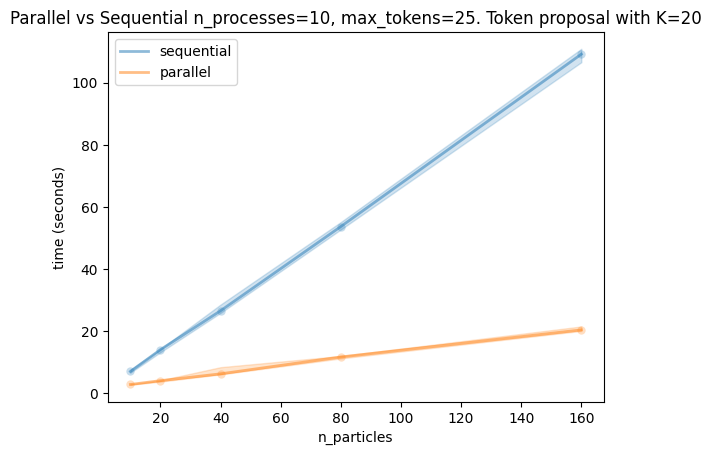

In [31]:
T.plot_feature('n_particles')

<Axes: title={'center': 'Parallel vs Sequential n_processes=10, max_tokens=25. Character Proposal.'}, xlabel='n_particles', ylabel='time (seconds)'>

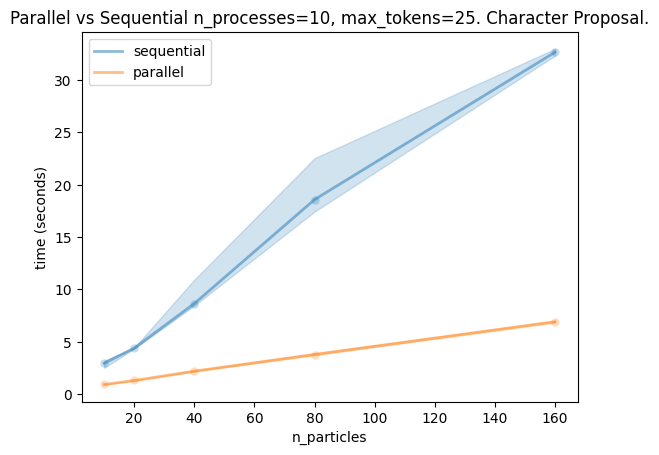

In [32]:
T2.plot_feature('n_particles')

In [21]:
baseline.next_token_logprob_server.add_prompt('Generate an SQL query:')

particles = init_particles(n_particles=200)
particles = baseline.batch_step(particles, is_initial=True)
while not all(p.done for p in particles):
    particles = baseline.batch_step(particles)

INFO 07-22 20:30:17 metrics.py:341] Avg prompt throughput: 1.1 tokens/s, Avg generation throughput: 77.8 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 07-22 20:30:35 metrics.py:341] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 0.2 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.1%, CPU KV cache usage: 0.0%.
INFO 07-22 20:30:40 metrics.py:341] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 5.9 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.6%, CPU KV cache usage: 0.0%.
INFO 07-22 20:30:48 metrics.py:341] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 8.4 tokens/s, Running: 1 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 1.5%, CPU KV cache usage: 0.0%.
INFO 07-22 20:30:55 metrics.py:341] Avg prompt throughput: 0.0 tokens/s, Avg generation throughput: 8.2 tokens/s, Running: 1 reqs, 

In [22]:
baseline.timer.compare()

vllm is 111.9831x faster than parser (p=0.00000, median: parser: 3.16078, vllm: 0.0282255)


In [23]:
batch_proposal.timer.compare()

vllm is 24.1656x faster than parser (p=0.00000, median: parser: 0.671341, vllm: 0.0277809)


<Axes: title={'center': 'Parallel vs Sequential n_processes=10, max_tokens=12'}, xlabel='n_particles', ylabel='time (seconds)'>

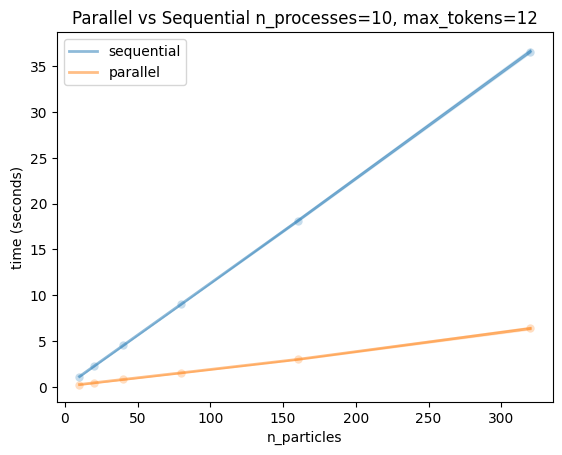

In [9]:
T.plot_feature('n_particles')